In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from scipy.stats import pearsonr
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

## evaluation

In [ ]:
def evaluation_metrics(y_test, y_pred, x_trn, n):
  R2 = metrics.r2_score(y_test, y_pred).round(4)
  Adjusted_R2 = (1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-x_trn.shape[1]-1)).round(4)
  MAE = metrics.mean_absolute_error(y_test, y_pred).round(4)
  MSE = metrics.mean_squared_error(y_test, y_pred).round(4)
  RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(4)
  Pearson_Correlation = pearsonr(y_test, y_pred)[0].round(4)

  evaluatin_table = pd.DataFrame.from_dict({"feature": n,
                                            "R^2": R2,
                                            "Adjusted R^2": Adjusted_R2,
                                            "MAE": MAE,
                                            "MSE": MSE,
                                            "RMSE": RMSE,
                                            "Pearson_Correlation": [Pearson_Correlation],
                                            }, 
  )

  return evaluatin_table

## Median Imputed Data

In [ ]:
training_impute_median = pd.read_csv('/content/drive/MyDrive/ML/median imputer/training_impute_median.csv')
training_impute_median_norm = pd.read_csv('/content/drive/MyDrive/ML/median imputer/training_impute_median_norm.csv')
testing_impute_median = pd.read_csv('/content/drive/MyDrive/ML/median imputer/testing_impute_median.csv')
testing_impute_median_norm = pd.read_csv('/content/drive/MyDrive/ML/median imputer/testing_impute_median_norm.csv')
validation_impute_median = pd.read_csv('/content/drive/MyDrive/ML/median imputer/validation_impute_median.csv')
validation_impute_median_norm = pd.read_csv('/content/drive/MyDrive/ML/median imputer/validation_impute_median_norm.csv')

In [ ]:
x_trn = training_impute_median.drop(columns=['subject_id','slope_following_9_months'])
y_trn = training_impute_median['slope_following_9_months']
x_tst = testing_impute_median.drop(columns=['subject_id','slope_following_9_months'])
y_tst = testing_impute_median['slope_following_9_months']
x_val = validation_impute_median.drop(columns=['subject_id','slope_following_9_months'])
y_val = validation_impute_median['slope_following_9_months']

In [ ]:
data_all = training_impute_median.append(testing_impute_median).append(validation_impute_median)
data_all = data_all.reset_index()
data = training_impute_median_norm.append(testing_impute_median)
X = x_trn.append(x_tst)
y = y_trn.append(y_tst)

In [ ]:
from time import time
from sklearn.ensemble import RandomForestRegressor
start_rf = time()
rf = RandomForestRegressor(random_state=2021)
rf.fit(x_trn, y_trn)
print('Random forest accuracy: {}'.format(rf.score(x_tst, y_tst)))


Random forest accuracy: 0.13146653887186366


In [ ]:
y_pred = rf.predict(x_tst)
runtime_rf = np.round(time()-start_rf,5)
print("rf", runtime_rf,"sec")
print(evaluation_metrics(y_tst, y_pred, x_tst,len(x_trn.columns)))

rf 26.83782 sec
   feature     R^2  Adjusted R^2     MAE     MSE    RMSE  Pearson_Correlation
0      325  0.1315       -2.6359  0.5399  0.6144  0.7838               0.3706


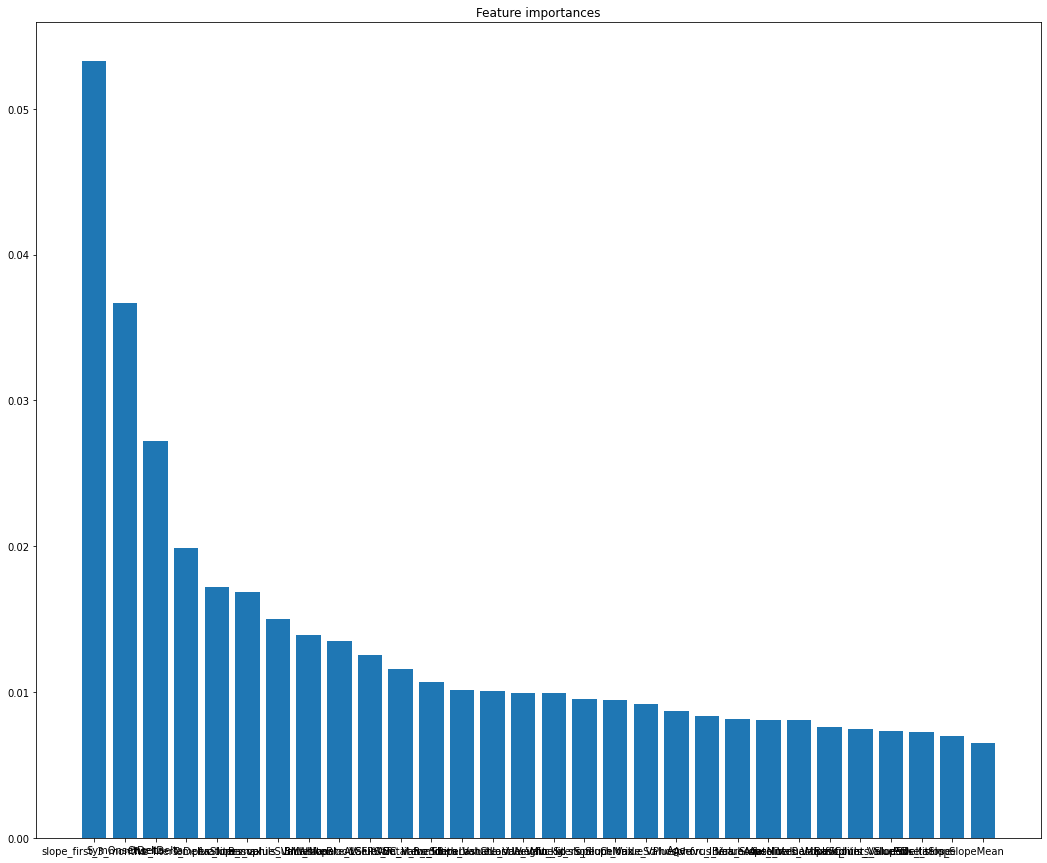

slope_first_3_months             0.053260
SymOnsetDelta                    0.036706
OnsetDelta                       0.027243
fvc_liters_DeltaSlope            0.019863
Temperature_max                  0.017217
fvc_liters_valueSum              0.016865
Basophils_ValueMax               0.014979
BMI_slope                        0.013914
Bicarbonate_ValueAve             0.013496
WhiteBloodCellWBC_ValueSd        0.012543
ALSFRS_Total_3_month             0.011564
fvc_liters_SlopeLast             0.010668
fvc_liters_ValueLast             0.010112
Bicarbonate_ValueMin             0.010094
Chloride_ValueSd                 0.009953
Weight_kg_slope                  0.009934
fvc_liters_SlopeMax              0.009494
Sodium_ValueSd                   0.009427
Chloride_ValueAve                0.009204
Age                              0.008705
Phosphorus_ValueAve              0.008391
fvc_liters_SlopeMin              0.008183
Bicarbonate_ValueMax             0.008115
fvc_liters_ValueStd              0

In [ ]:
importances = rf.feature_importances_  # plot feature importance
indices = np.argsort(importances)[::-1][0:30]  

plt.figure(figsize=(18,15))
plt.title("Feature importances")
plt.xticks(np.arange(30), x_trn.columns[indices[0:29]].values)
plt.bar(np.arange(30), importances[indices], align="center")
plt.show()
feat_imp = pd.Series(rf.feature_importances_, x_trn.columns).sort_values(ascending=False)[:30]
print(feat_imp)

In [ ]:
df_feat_imp = pd.DataFrame(feat_imp)
df_feat_imp
df_feat_imp.to_csv("random_forest_top_features.csv")  
!cp random_forest_top_features.csv "drive/My Drive/"

##GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score


param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}


model_rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = model_rf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_trn, y_trn)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [ ]:
grid_search.fit(x_trn, y_trn)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 100}

In [ ]:
best_grid=RandomForestRegressor(bootstrap=True, max_depth=110, max_features=3,min_samples_leaf=3, min_samples_split=10,n_estimators=200)

best_grid.fit(x_trn,y_trn) 
y_pred1=best_grid.predict(x_tst)
evaluatin_table = evaluation_metrics(y_tst, y_pred1, x_trn,len(x_trn.columns))
print("Median imputation, Random Search Best Model")
evaluatin_table


Median imputation, Random Search Best Model


,feature,R^2,Adjusted R^2,MAE,MSE,RMSE,Pearson_Correlation
0,325,0.0928,-2.7978,0.5689,0.6417,0.8011,0.3596


##RandomizedSearchCV

In [ ]:
import pprint
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 20, stop = 300, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [20, 51, 82, 113, 144, 175, 206, 237, 268, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=2021, n_jobs = -1)

print(rf)
print(rf_random)
rf_random.fit(x_trn, y_trn)


RandomForestRegressor()
RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 51, 82, 113, 144,
                                                         175, 206, 237, 268,
                                                         300]},
                   random_state=2021, verbose=2)
Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 51, 82, 113, 144,
                                                         175, 206, 237, 268,
                                                         300]},
                   random_state=2021, verbose=2)

In [ ]:

rf_random.best_params_


{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 144}

In [ ]:
runtime_rf = np.round(time()-start_rf,5)
best_randomsearch=RandomForestRegressor(bootstrap=True, max_depth=30, max_features='auto',min_samples_leaf=4, min_samples_split=32,n_estimators=144)

best_randomsearch.fit(x_trn,y_trn) 
y_pred1=best_randomsearch.predict(x_tst)
evaluatin_table = evaluation_metrics(y_tst, y_pred1, x_trn,len(x_trn.columns))
print("Median imputation, Random Search Best Model")
evaluatin_table


Median imputation, Random Search Best Model


,feature,R^2,Adjusted R^2,MAE,MSE,RMSE,Pearson_Correlation
0,325,0.1746,-2.4553,0.53,0.5838,0.7641,0.4254


In [ ]:
runtime_rf = np.round(time()-start_rf,5)
rf = RandomForestRegressor(random_state=2021)
print("rf", runtime_rf,"sec")

rf 4940.9788 sec


In [ ]:

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=2021, n_jobs = -1)

print(rf)
print(rf_random)

rf_random.fit(X, y)

RandomForestRegressor()
RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 51, 82, 113, 144,
                                                         175, 206, 237, 268,
                                                         300]},
                   random_state=2021, verbose=2)
Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 51, 82, 113, 144,
                                                         175, 206, 237, 268,
                                                         300]},
                   random_state=2021, verbose=2)

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 144}

In [ ]:
start_rf = time()
best=RandomForestRegressor(bootstrap=True, max_depth=90, max_features='auto',min_samples_leaf=4, min_samples_split=10,n_estimators=237,random_state=2021)

best.fit(x_trn,y_trn) 
y_pred_test=best.predict(x_tst)
y_pred_train=best.predict(x_trn)
runtime_rf = np.round(time()-start_rf,5)
evaluatin_table = evaluation_metrics(y_tst, y_pred_test, x_tst,len(x_trn.columns))
print("runtime", runtime_rf,"sec")
print("Median imputation, Random Search Best Model")
evaluatin_table

runtime 43.34575 sec
Median imputation, Random Search Best Model


,feature,R^2,Adjusted R^2,MAE,MSE,RMSE,Pearson_Correlation
0,325,0.1795,-2.435,0.5295,0.5804,0.7618,0.4316


## validation

In [ ]:
start_rf = time()
best_rf = RandomForestRegressor(bootstrap=True, max_depth=30, max_features='auto',min_samples_leaf=4, min_samples_split=32,n_estimators=144)
best_rf.fit(X,y)
y_pred = best_rf.predict(x_val)
runtime_rf = np.round(time()-start_rf,5)
print("runtime", runtime_rf,"sec")
print(evaluation_metrics(y_val, y_pred, x_val,len(x_val.columns)))

runtime 32.15859 sec
   feature   R^2  Adjusted R^2     MAE     MSE    RMSE  Pearson_Correlation
0      325  0.13       -0.2589  0.6111  0.8075  0.8986               0.3646


In [ ]:

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=2021, n_jobs = -1)

print(rf)
print(rf_random)

rf_random.fit(X, y)

RandomForestRegressor()
RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 51, 82, 113, 144,
                                                         175, 206, 237, 268,
                                                         300]},
                   random_state=2021, verbose=2)
Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 51, 82, 113, 144,
                                                         175, 206, 237, 268,
                                                         300]},
                   random_state=2021, verbose=2)

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 144}

In [ ]:
start_rf = time()
rf = RandomForestRegressor(bootstrap=True, max_depth=90, max_features='auto',min_samples_leaf=4, min_samples_split=10,n_estimators=237,random_state=2021)
rf.fit(X,y)
y_pred_val = rf.predict(x_val)
y_pred_test=rf.predict(x_tst)
y_pred_train=rf.predict(x_trn)
runtime_rf = np.round(time()-start_rf,5)
print("runtime", runtime_rf,"sec")
print(evaluation_metrics(y_val, y_pred_val, x_val,len(x_val.columns)))


runtime 58.63136 sec
   feature     R^2  Adjusted R^2     MAE     MSE    RMSE  Pearson_Correlation
0      325  0.1297       -0.2594  0.6091  0.8078  0.8988               0.3628


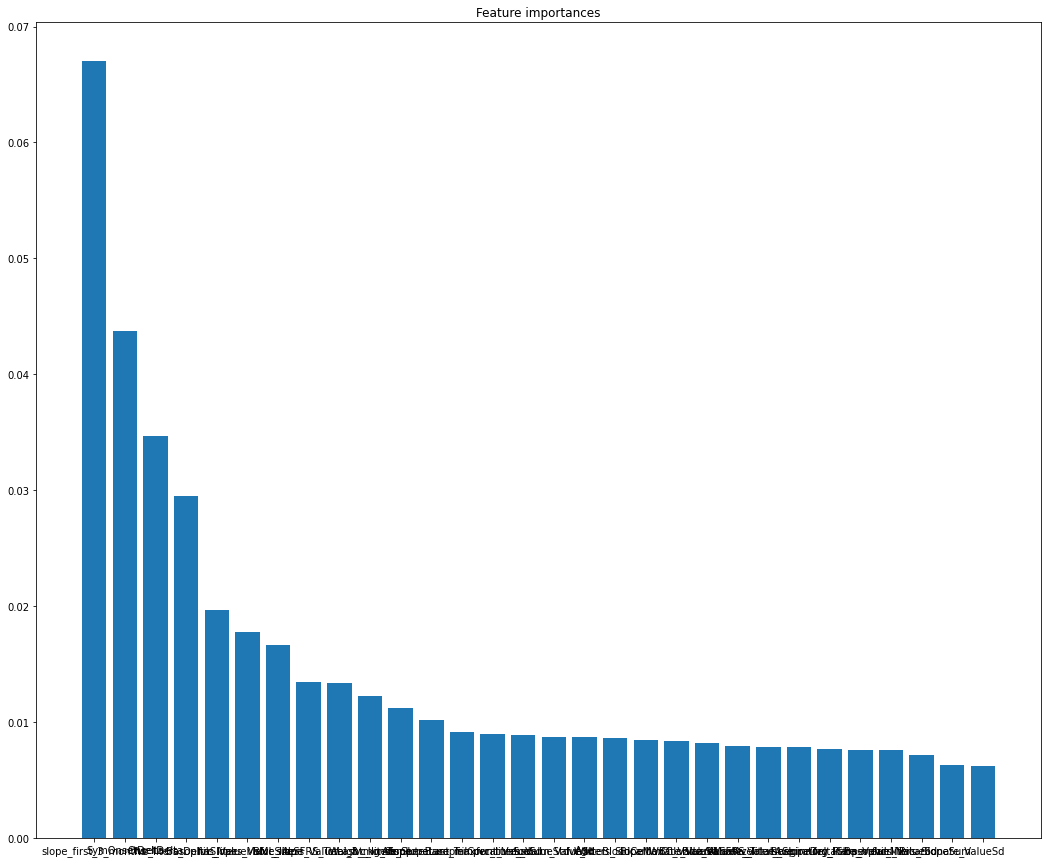

slope_first_3_months             0.066999
SymOnsetDelta                    0.043752
OnsetDelta                       0.034672
fvc_liters_DeltaSlope            0.029535
Basophils_ValueMax               0.019632
fvc_liters_valueSum              0.017790
BMI_slope                        0.016663
fvc_liters_ValueLast             0.013451
ALSFRS_Total_3_month             0.013332
Weight_kg_slope                  0.012280
fvc_liters_SlopeLast             0.011223
Temperature_max                  0.010211
AbsoluteBasophilCount_ValueSd    0.009165
Temperature_sd                   0.008980
fvc_liters_ValueStd              0.008846
Sodium_ValueSd                   0.008673
Age                              0.008670
fvc_liters_SlopeMax              0.008626
WhiteBloodCellWBC_ValueSd        0.008424
Bicarbonate_ValueMax             0.008359
Chloride_ValueAve                0.008169
Bicarbonate_ValueAve             0.007890
ALSFRS_Total_beginning           0.007838
fvc_liters_SlopeDeltaSlope       0

In [ ]:
importances = rf.feature_importances_  # plot feature importance
indices = np.argsort(importances)[::-1][0:30]  

plt.figure(figsize=(18,15))
plt.title("Feature importances")
plt.xticks(np.arange(30), x_trn.columns[indices[0:29]].values)
plt.bar(np.arange(30), importances[indices], align="center")
plt.show()
feat_imp = pd.Series(rf.feature_importances_, x_trn.columns).sort_values(ascending=False)[:30]
print(feat_imp)

# Analysis

In [ ]:
output_y = pd.DataFrame.from_dict({
    "subject_id": data_all['subject_id'],
    "y_pred": np.append(np.append(y_pred_train,y_pred_test),y_pred_val),
    "y_true": data_all['slope_following_9_months']
})
output_y


,subject_id,y_pred,y_true
0,553099,-0.898914,-0.887366
1,8471,-1.018988,-0.954460
2,534458,-0.683636,-0.521771
3,225766,-0.775526,-0.454279
4,161271,-0.653791,-0.457694
...,...,...,...
3186,993900,-0.750912,-0.699693
3187,994973,-0.680297,-0.385274
3188,995546,-0.721519,-0.378880
3189,996401,-0.389917,-1.104556


In [ ]:
output_y.describe()


,subject_id,y_pred,y_true
count,3191.000000,3191.000000,3191.000000
mean,499666.061736,-0.859349,-0.857436
std,291684.227591,0.454317,0.944191
min,329.000000,-3.014543,-8.056765
25%,246779.500000,-1.114786,-1.257713
50%,499325.000000,-0.800347,-0.691742
75%,752560.000000,-0.552946,-0.252065
max,999990.000000,1.612820,7.609167


Text(0, 0.5, 'y_true')

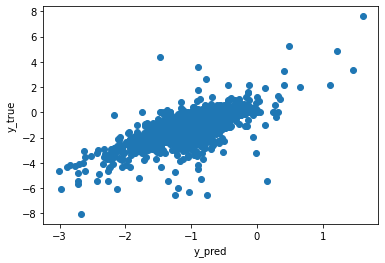

In [ ]:
plt.scatter(output_y['y_pred'], output_y['y_true'])
plt.xlabel("y_pred")
plt.ylabel("y_true")

(-8.840061274650001, 8.39246323565)

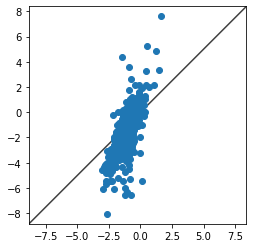

In [ ]:
fig, ax = plt.subplots()
ax.scatter(output_y['y_pred'], output_y['y_true'])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

## Remove outliers

In [ ]:
from scipy import stats
z = np.abs(stats.zscore(data_all['slope_following_9_months']))
z

array([0.03170424, 0.1027747 , 0.35556102, ..., 0.50692257, 0.26176806,
       0.35556102])

In [ ]:
threshold = 3
outliers = np.where(z > threshold)[0]
outliers

array([  51,   62,   82,  133,  146,  179,  246,  247,  507,  607,  694,
        722,  734,  752,  755,  821,  855,  874,  880,  924,  985, 1046,
       1088, 1187, 1321, 1324, 1398, 1406, 1444, 1541, 1568, 1592, 1609,
       1622, 1700, 1736, 1829, 1868, 1879, 1936, 2205, 2258, 2411, 2433,
       2482, 2557, 2572, 2592, 2677, 2711, 2724, 2725, 2749, 2756, 2809,
       3013, 3050])

In [ ]:
output_y.iloc[outliers.tolist(),:]

,subject_id,y_pred,y_true
51,303218,-2.983985,-6.087333
62,380751,-0.117834,2.174048
82,330665,-1.708823,-3.804583
133,770063,-2.278830,-3.726939
146,525197,-2.258219,-5.435119
179,151434,-2.719880,-4.782905
246,230778,-2.080977,-3.726939
247,295093,-2.640506,-3.985754
507,584290,-1.455345,-4.348095
607,340898,0.492411,5.247701


In [ ]:
len(outliers)

57

In [ ]:
output_y.iloc[outliers.tolist(),:]

,subject_id,y_pred,y_true
51,303218,-2.983985,-6.087333
62,380751,-0.117834,2.174048
82,330665,-1.708823,-3.804583
133,770063,-2.278830,-3.726939
146,525197,-2.258219,-5.435119
179,151434,-2.719880,-4.782905
246,230778,-2.080977,-3.726939
247,295093,-2.640506,-3.985754
507,584290,-1.455345,-4.348095
607,340898,0.492411,5.247701


In [ ]:
output_no_outliers = output_y.drop(index=outliers)
output_no_outliers

,subject_id,y_pred,y_true
0,553099,-0.898914,-0.887366
1,8471,-1.018988,-0.954460
2,534458,-0.683636,-0.521771
3,225766,-0.775526,-0.454279
4,161271,-0.653791,-0.457694
...,...,...,...
3186,993900,-0.750912,-0.699693
3187,994973,-0.680297,-0.385274
3188,995546,-0.721519,-0.378880
3189,996401,-0.389917,-1.104556


In [ ]:
MSE = metrics.mean_squared_error(output_no_outliers['y_true'], output_no_outliers['y_pred']).round(4)
MSE

0.2642

In [ ]:
Pearson_Correlation = pearsonr(output_no_outliers['y_true'], output_no_outliers['y_pred'])[0].round(4)
Pearson_Correlation

0.7764

#Numbers of Features

In [ ]:
feature_subset = feature_subset_top150.append(feature_subset_bottom150)
feature_subset = list(feature_subset.index)

NameError: ignored

In [ ]:
X = data_used.drop(columns='slope_following_9_months')[feature_subset]
y = data_used['slope_following_9_months']

In [ ]:
n_features = [10,20,50,100,150,200,250,300]
# evaluation_metrics_results = pd.DataFrame()
for n in n_features:
  X = data_used.drop(columns='slope_following_9_months')[feature_subset]
  X = X.iloc[:,0:n]
  print(X.shape)
  x_trn, x_tst, y_trn, y_tst = train_test_split(X, 
                                                y, 
                                                test_size=0.2,
                                                random_state=2021)
  start_rf = time()
  rf = RandomForestRegressor(random_state=2021)
  rf.fit(x_trn, y_trn)
  print('Random forest accuracy: {}'.format(rf.score(x_tst, y_tst)))
  
  y_pred = rf.predict(x_tst)
  runtime_rf = np.round(time()-start_rf,5)

  runtime = str(runtime_rf) + "sec"
  evaluation_metrics_result = evaluation_metrics(y_tst, y_pred, x_tst, n)
  # evaluation_metrics_results.append(evaluation_metrics_result)
  print(runtime)
  print(evaluation_metrics_result)
  importances = rf.feature_importances_  # plot feature importance
  indices = np.argsort(importances)[::-1][0:10]  # the first 10 features (all numbers add up to 1)

  plt.figure(figsize=(18,15))
  plt.title("Feature importances")
  plt.xticks(np.arange(10), x_trn.columns[indices[0:10]].values)
  plt.bar(np.arange(10), importances[indices], align="center")
  plt.show()
  print(x_trn.columns[indices[0:10]].values)
# evaluation_metrics_results

# KNN Imputated Data

In [ ]:
testing_impute_knn = pd.read_csv('/content/drive/MyDrive/ML/knn imputer/testing_impute_knn.csv')
testing_impute_knn_norm = pd.read_csv('/content/drive/MyDrive/ML/knn imputer/testing_impute_knn_norm.csv')
training_impute_knn = pd.read_csv('/content/drive/MyDrive/ML/knn imputer/training_impute_knn.csv')
training_impute_knn_norm = pd.read_csv('/content/drive/MyDrive/ML/knn imputer/training_impute_knn_norm.csv')
validation_impute_knn = pd.read_csv('/content/drive/MyDrive/ML/knn imputer/validation_impute_knn.csv')
validation_impute_knn_norm = pd.read_csv('/content/drive/MyDrive/ML/knn imputer/validation_impute_knn_norm.csv')

In [ ]:
data_used = training_impute_knn.drop(columns=['subject_id'])
X = data_used.drop(columns='slope_following_9_months')
y = data_used['slope_following_9_months']

In [ ]:
x_trn = training_impute_knn.drop(columns=['subject_id','slope_following_9_months'])
y_trn = training_impute_knn['slope_following_9_months']
x_tst = testing_impute_knn.drop(columns=['subject_id','slope_following_9_months'])
y_tst = testing_impute_knn['slope_following_9_months']


In [ ]:
from time import time
from sklearn.ensemble import RandomForestRegressor
start_rf = time()
rf = RandomForestRegressor(random_state=2021)
rf.fit(x_trn, y_trn)
print('Random forest accuracy: {}'.format(rf.score(x_tst, y_tst)))


In [ ]:
y_pred = rf.predict(x_tst)
runtime_rf = np.round(time()-start_rf,5)
print("rf", runtime_rf,"sec")
print(evaluation_metrics(y_tst, y_pred, x_tst,len(x_trn.columns)))

In [ ]:
importances = rf.feature_importances_  # plot feature importance
indices = np.argsort(importances)[::-1][0:10]  # the first 10 features (all numbers add up to 1)

plt.figure(figsize=(18,15))
plt.title("Feature importances")
plt.xticks(np.arange(10), x_trn.columns[indices[0:10]].values)
plt.bar(np.arange(10), importances[indices], align="center")
plt.show()

number of features

In [ ]:
feature_subset_top150 = data_used.corr()[['slope_following_9_months']].sort_values(by='slope_following_9_months', ascending=False).drop('slope_following_9_months')[0:150]
feature_subset_bottom150 = data_used.corr()[['slope_following_9_months']].sort_values(by='slope_following_9_months', ascending=True).drop('slope_following_9_months')[0:150]

In [ ]:
feature_subset = feature_subset_top150.append(feature_subset_bottom150)
feature_subset = list(feature_subset.index)

In [ ]:
X = data_used.drop(columns='slope_following_9_months')[feature_subset]
y = data_used['slope_following_9_months']

In [ ]:
n_features = [10,20,50,100,150,200,250,300]
# evaluation_metrics_results = pd.DataFrame()
for n in n_features:
  X = data_used.drop(columns='slope_following_9_months')[feature_subset]
  X = X.iloc[:,0:n]
  print(X.shape)
  x_trn, x_tst, y_trn, y_tst = train_test_split(X, 
                                                y, 
                                                test_size=0.2,
                                                random_state=2021)
  start_rf = time()
  rf = RandomForestRegressor(random_state=2021)
  rf.fit(x_trn, y_trn)
  print('Random forest accuracy: {}'.format(rf.score(x_tst, y_tst)))
  
  y_pred = rf.predict(x_tst)
  runtime_rf = np.round(time()-start_rf,5)

  runtime = str(runtime_rf) + "sec"
  evaluation_metrics_result = evaluation_metrics(y_tst, y_pred, x_tst, n)
  # evaluation_metrics_results.append(evaluation_metrics_result)
  print(runtime)
  print(evaluation_metrics_result)
  importances = rf.feature_importances_  # plot feature importance
  indices = np.argsort(importances)[::-1][0:10]  # the first 10 features (all numbers add up to 1)

  plt.figure(figsize=(18,15))
  plt.title("Feature importances")
  plt.xticks(np.arange(10), x_trn.columns[indices[0:10]].values)
  plt.bar(np.arange(10), importances[indices], align="center")
  plt.show()
  print(x_trn.columns[indices[0:10]].values)
  
# evaluation_metrics_results